In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from utils.DataLoaderTest import DataLoaderTest as DLT
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

In [ ]:
torch.cuda.empty_cache()

In [ ]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [ ]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_rol_ht_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_ht_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"
bad_pairs_path = "C:/Cours-Sorbonne/M1/Stage/src/files/bad_pairs.txt"
to_enhance_path = "C:/Cours-Sorbonne/M1/Stage/src/files/to_enhance_pairs.txt"
path_sim_rol_test = "C:/Cours-Sorbonne/M1/Stage/src/data/data_PPTI/sim_rol_test"

if SSH:
    path_rol_ht_super_comp = "../data/rol_ht_super_compressed" 
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_sim_rol_test = "../data/sim_rol_test"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"
    bad_pairs_path = "./files/bad_pairs.txt"
    to_enhance_path = "./files/to_enhance_pairs.txt"

## Params

In [ ]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [ ]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered,
    shape=(image_size, image_size), target_path=path_targets,
    to_enhance_path=to_enhance_path, bad_pairs_path=bad_pairs_path,
    path_sim_rol_test=path_sim_rol_test, max_images=40000,
    augment_test=False, use_only_rol=True, remove_to_enhance_files=True, remove_bad_pairs=True, remove_sub_testset=True
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [ ]:
DSC.show_data(train_loader,1)
DSC.show_data(val_loader,1)

# Approche Supervisé

In [ ]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-RGN-RT") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs
)

In [ ]:
trainer.save("model_simclr_RGN_RT.pth","history_simclr_RGN_RT.txt")

## Testing

In [20]:
testset = DLT(path_to_sim_test=path_sim_rol_test, augment=False)

In [18]:
testset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered,
    shape=(image_size, image_size), target_path=path_targets,
    to_enhance_path=to_enhance_path, bad_pairs_path=bad_pairs_path,
    path_sim_rol_test=path_sim_rol_test, max_images=40000,
    augment_test=False, use_only_rol=False, remove_to_enhance_files=False, remove_bad_pairs=True, remove_sub_testset=False
)

[INFO] Loaded exsisting targets
[INFO] Before filtering : 1926 images
[INFO] After filtering : 1466 images


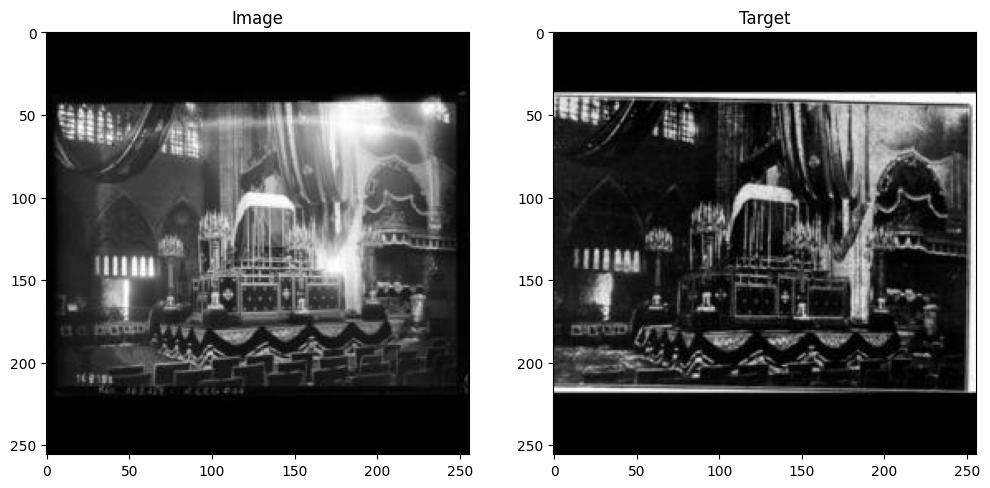

In [22]:
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
DSC.show_data(test_loader, 1, is_test=True)

In [ ]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("C:/Cours-Sorbonne/M1/Stage/src/params/model/model_simclr_RGC.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("C:/Cours-Sorbonne/M1/Stage/src/params/model/history_simclr_RGC.txt")

## Calculate Top-K precision

In [ ]:
top_k_pairs, original_images, augmented_images, precisions = SMY.match_images_with_simCLR(
    model, test_loader=test_loader, use_context=True, k=100, use_sift=True, is_test=True, alpha=0.4
)

In [ ]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=20)

## Calculate Top-K precision with SIFT

In [ ]:
top_k_pairs, original_images, augmented_images, sift_precisions = SMY.match_images_with_simCLR(
    model, test_loader=test_loader, use_context=True, k=100, use_sift=True, is_test=True, alpha=0.4
)

In [ ]:
best_pairs = top_k_pairs[:,0]
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=20)

## Calculate Top-1 precision reranked on Top-K with SIFT

In [ ]:
top_k = [i for i in range(0,105, 5)]
top_k[0] = 1

top_1_precisions = []
for i in top_k:
    top_k_pairs, original_images, augmented_images, precisions = SMY.match_images_with_simCLR(
        model, test_loader=test_loader, use_context=True, k=i, use_sift=True, is_test=True, alpha=0.4
    )
    top_1_precisions.append(precisions[0])

In [ ]:
import matplotlib.pyplot as plt


top_k = [i for i in range(0,105, 5)]
top_k[0] = 1

plt.style.use('ggplot')
plt.figure(figsize=(12, 7))
plt.plot(top_k, sift_precisions, marker='o', label="Precision SIFT ON")  # Match precisions with top_k
plt.plot(top_k, precisions, marker='o', label="Precision SIFT OFF")  # Match precisions with top_k
plt.plot(top_k, top_1_precisions, marker='o', label="Precision Top 1 after reranking Top K")  # Match precisions with top_k

plt.xlabel("Top k pairs")
plt.ylabel("Precision")
plt.xticks(top_k)  
plt.legend()
plt.title("Precision of top k pairs")
plt.show()